# Import libraries and tools

In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


# Load Dataset

In [24]:
train_dir = "MRI_Images/Training"
test_dir = "MRI_Images/Testing"

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
       train_paths.append(os.path.join(train_dir, label, image))
       train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
       test_paths.append(os.path.join(test_dir, label, image))
       test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

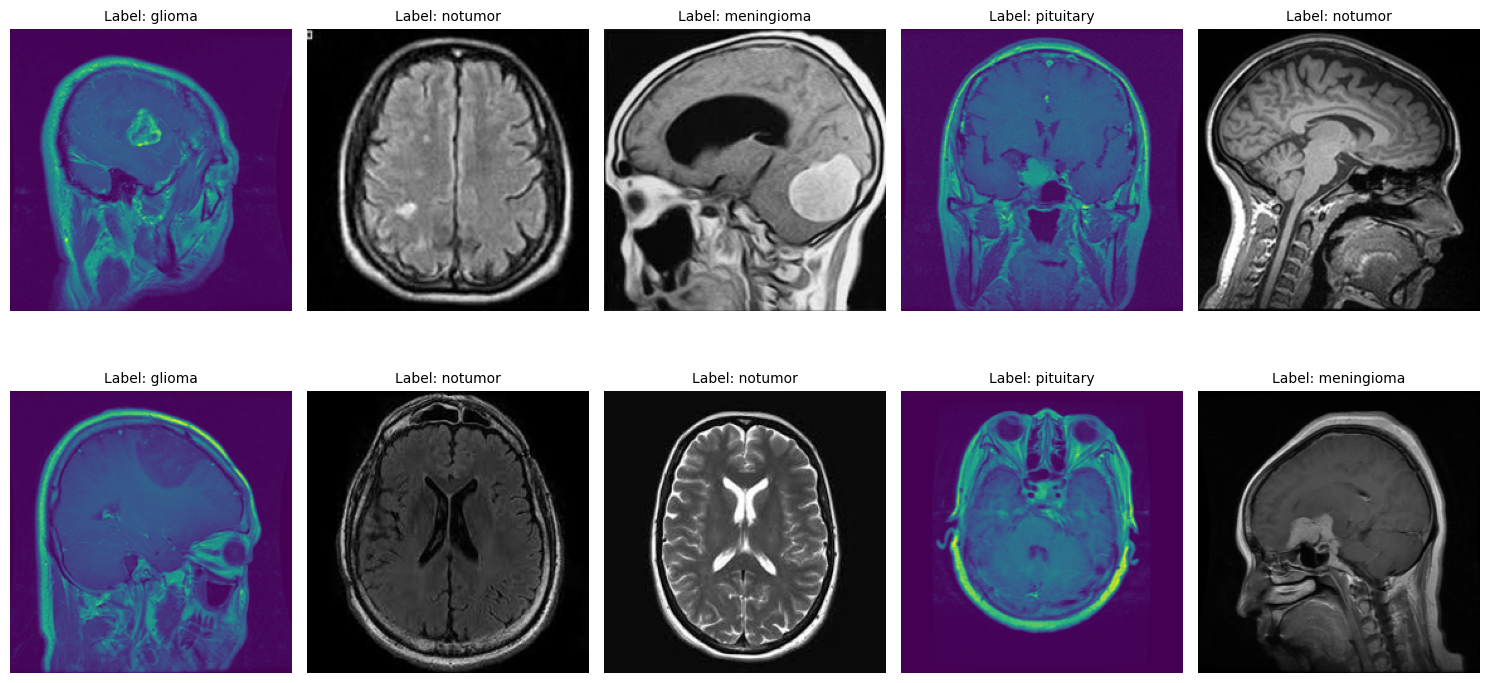

In [25]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

# Image Preprocessing (Helper Functions)

In [26]:

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

# MODEL

In [27]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5
 
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 232s 793ms/step - loss: 0.4440 - sparse_categorical_accuracy: 0.8346
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 224s 786ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9125
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 223s 782ms/step - loss: 0.1581 - sparse_categorical_accuracy: 0.9389
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 219s 768ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9578
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 221s 776ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9670


# Train and val Plots



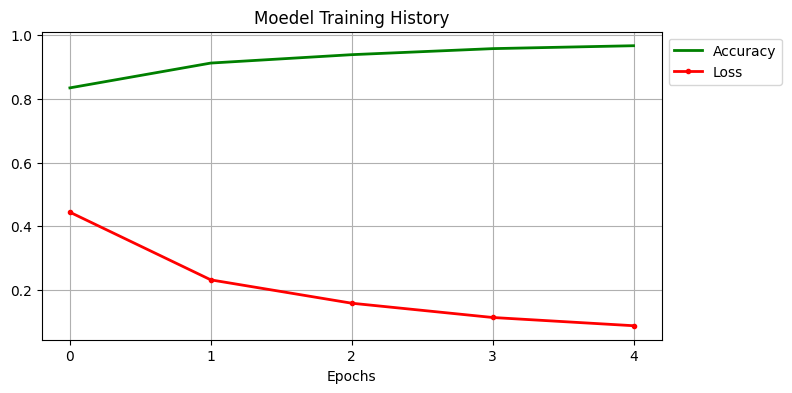

In [28]:
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '-g', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Moedel Training History')
plt.xlabel('Epochs')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'],loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))



41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       300
           1       0.90      0.93      0.92       306
           2       0.96      1.00      0.98       405
           3       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



# Model Confusion Plot

Confusion Matrix:
[[266  30   2   2]
 [  8 286   8   4]
 [  0   0 405   0]
 [  0   2   5 293]]


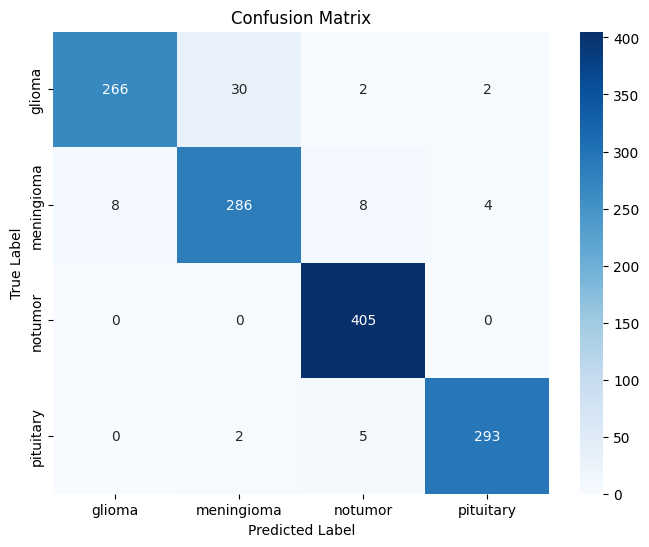

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ROC Curve Plot

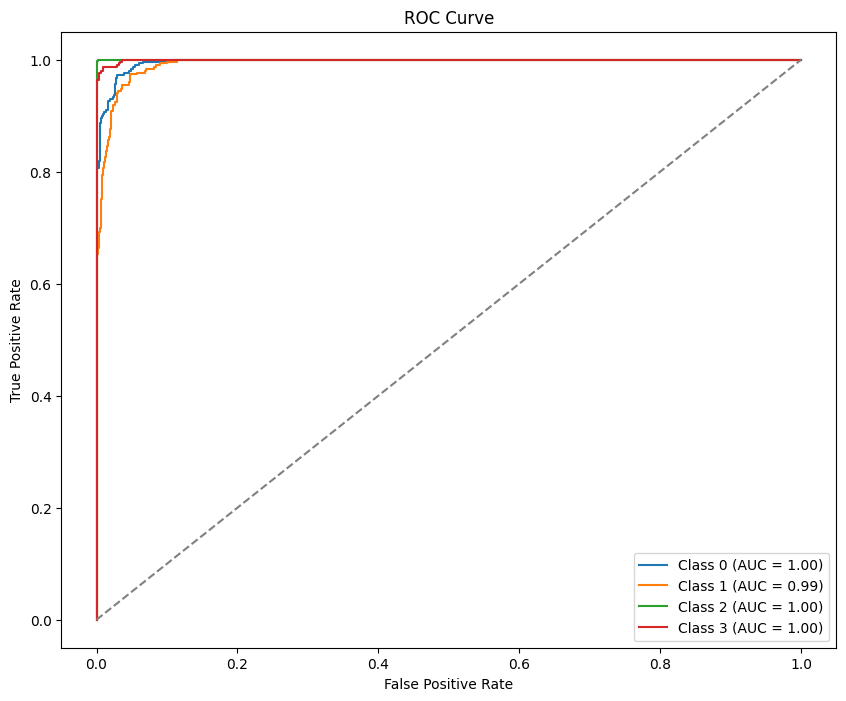

In [41]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

fpr,tpr,roc_auc = {} , {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle = '--' ,color='gray')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Save and Load Model

In [42]:
model.save('model.h5')

In [43]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# MRI Tumor Detection System

In [45]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ['pituitary','glioma','notumor','meningioma']  # Ensure class labels are defined


def detect_and_display(image_path,model):
    try:
        img = load_img(image_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Normalize and add batch dimension
        #prediction
        predictions = model.predict(img_array) # 0=0.90 , 1 =0.60 ,2 = 0.99, 3=0.40
        predicted_class_index = np.argmax(predictions)
        confidence_score = np.max(predictions,axis=1)[0]

        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor Detected"
        else:
            result= f"Tumor Detected: {class_labels[predicted_class_index]}"


        plt.imshow(load_img(image_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: ) {confidence_score * 100 : .2f}%")
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


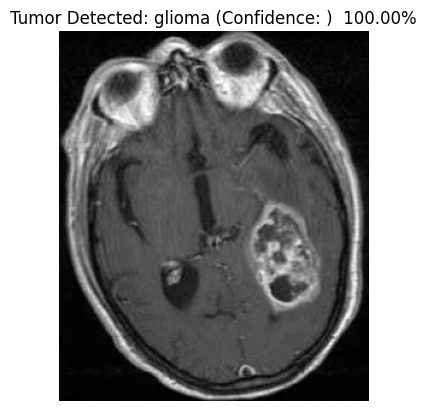

In [46]:
image_path = 'MRI_Images/Testing/meningioma/Te-meTr_0001.jpg' # Replace with your image path
detect_and_display(image_path,model)